# Exploring Global Warming Data


## The Dataset 


## The Proposed Study



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
pd.options.display.max_rows = 100000

In [2]:
df = pd.read_csv("data/global_warming/GlobalLandTemperaturesByCity.csv", parse_dates=[0])

In [3]:
print(df.columns.to_list())

['dt', 'AverageTemperature', 'AverageTemperatureUncertainty', 'City', 'Country', 'Latitude', 'Longitude']


In [4]:
df.dtypes

dt                               datetime64[ns]
AverageTemperature                      float64
AverageTemperatureUncertainty           float64
City                                     object
Country                                  object
Latitude                                 object
Longitude                                object
dtype: object

## Data Quality Assessment

There is a large number of NA values, especially for early years, also the number of observation reported for early years is much lower, due to the fact that there weren't measurements for certain cities, or that city perhaps not developed yet.

In [5]:
df_counts = (df.groupby(df.dt.dt.year)
             .count()
             .rename(columns={"dt":"total_counts","AverageTemperature":"Not_na_counts"})
             .reset_index()
            )

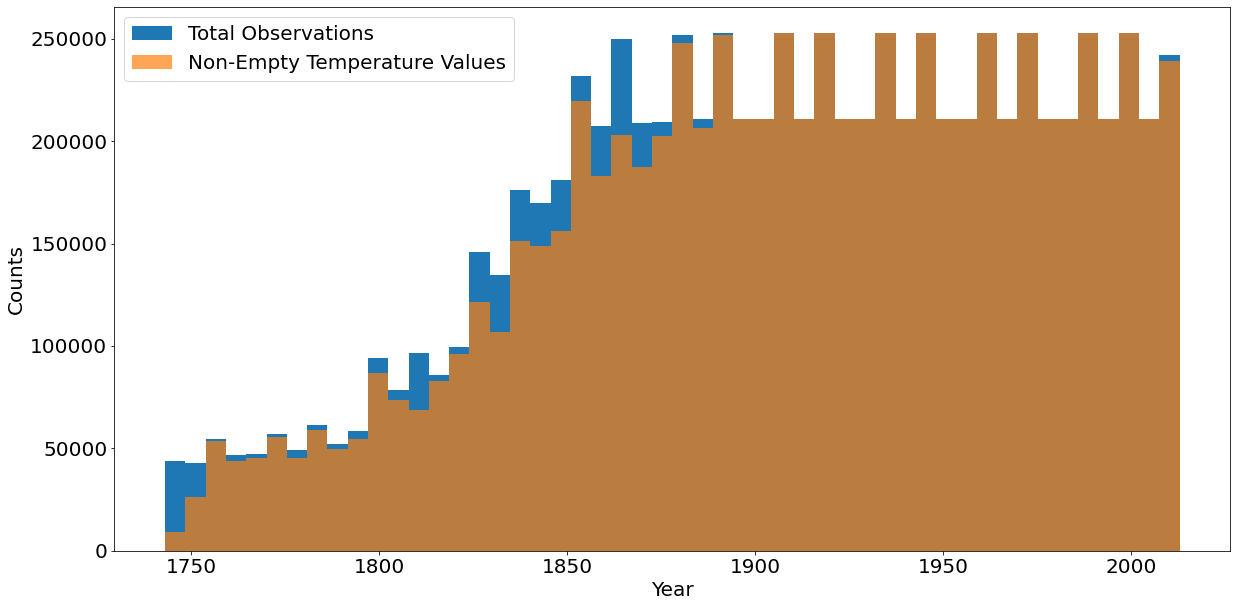

In [6]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.tick_params(axis='both', which='major', labelsize=20)
plt.hist(df_counts.dt, weights=df_counts.total_counts, bins=50 )
plt.hist(df_counts.dt, weights=df_counts.Not_na_counts, bins=50, alpha=0.7)
plt.xlabel('Year',fontsize=20)
plt.ylabel('Counts',fontsize=20)
plt.legend(["Total Observations","Non-Empty Temperature Values"],fontsize=20)
plt.show()

The uncertainty on the temperature has a large variance for years below 1900 and it is relatively higher due to tecnology difference.

<AxesSubplot:xlabel='Year', ylabel='Average Temperature Uncertainty [C]'>

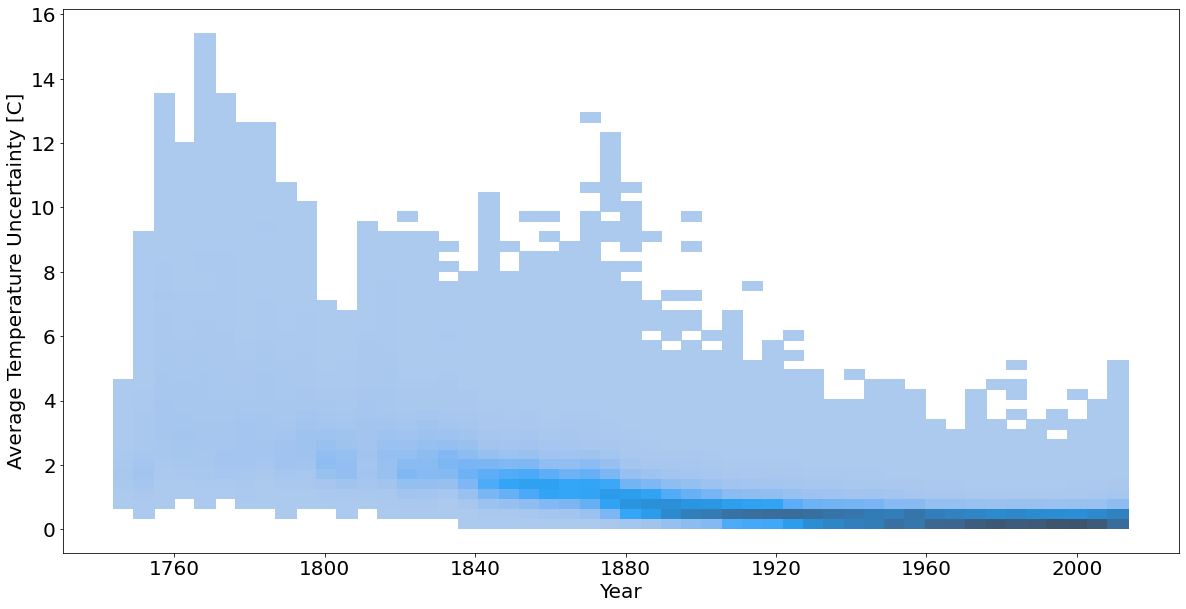

In [7]:
fig, ax2 = plt.subplots(figsize=(20,10))
ax2.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Year',fontsize=20)
plt.ylabel('Average Temperature Uncertainty [C]',fontsize=20)
sns.color_palette("mako", as_cmap=True)
sns.histplot(x="dt", y="AverageTemperatureUncertainty", data=df, bins=50)

Now in this analysis we need a representative sample of temperatures from the past and a representative sample of temperature of the present. Since the data is by city, and data from many cities are missing in the past this can affect the outcome of the analysis (we need to compare to the same locations). Also the uncertainty of the temperature measurments is correlated with the year, beacuase of technology advancement. We decide then to select data above year 1900, because is more unifor in location, has very few missing values and is more uniform in measurement uncertainty.

## Data Exploration

In [8]:
df_sel = df.loc[df.dt.dt.year > 1900 ]
#sns.scatterplot(x="dt", y="AverageTemperature", data=df)
df_sel.dt.dt

In [9]:
y,bins = np.histogram(df_sel.dt.dt.year, bins=20)
s = pd.DataFrame()

for idx in range(len(bins)-1):
    temp_df = df_sel.loc[(df_sel.dt.dt.year > bins[idx]) & (df_sel.dt.dt.year < bins[idx+1])]["AverageTemperature"]
    temp_df = temp_df.reset_index() # needed to have main index from zero
    temp_df["Year"] = int((bins[idx]+bins[idx+1])/2)
    s= s.append(temp_df) # appending histogrammed years
s = s.reset_index()
s = s.drop(["level_0","index"],axis=1)


<AxesSubplot:xlabel='Year', ylabel='AverageTemperature'>

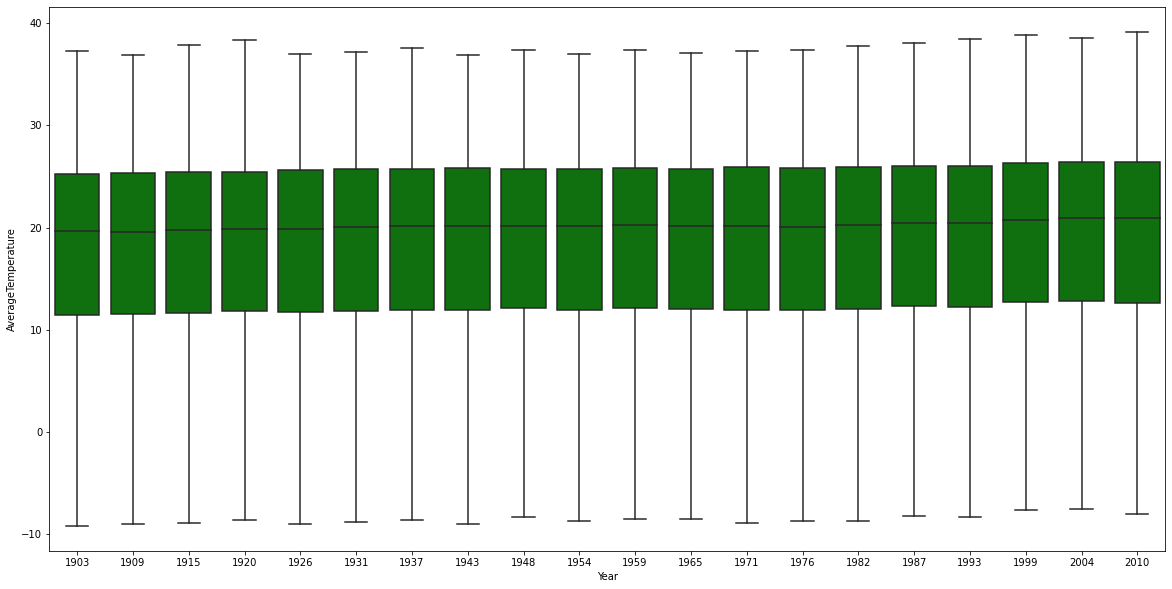

In [10]:
fig, ax3 = plt.subplots(figsize=(20,10))
sns.boxplot(x="Year",y="AverageTemperature",data=s, ax=ax3, color="green", showfliers=False)

In [11]:
df.groupby("dt")["AverageTemperature"].mean()

dt
1743-11-01     4.882424
1743-12-01          NaN
1744-01-01          NaN
1744-02-01          NaN
1744-03-01          NaN
1744-04-01     9.737433
1744-05-01    12.685514
1744-06-01    16.868296
1744-07-01    18.844524
1744-08-01          NaN
1744-09-01    14.316602
1744-10-01     8.719062
1744-11-01     4.636592
1744-12-01     0.064351
1745-01-01    -2.257734
1745-02-01    -1.359476
1745-03-01     1.916215
1745-04-01     7.691365
1745-05-01          NaN
1745-06-01          NaN
1745-07-01          NaN
1745-08-01          NaN
1745-09-01          NaN
1745-10-01          NaN
1745-11-01          NaN
1745-12-01          NaN
1746-01-01          NaN
1746-02-01          NaN
1746-03-01          NaN
1746-04-01          NaN
1746-05-01          NaN
1746-06-01          NaN
1746-07-01          NaN
1746-08-01          NaN
1746-09-01          NaN
1746-10-01          NaN
1746-11-01          NaN
1746-12-01          NaN
1747-01-01          NaN
1747-02-01          NaN
1747-03-01          NaN
1747-04-01   

In [13]:
df_rome = df[df.City == "Rome"]

In [14]:
df_rome["month"] = df_rome.dt.dt.month.copy()

<ipython-input-14-5a2a5e7be614>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rome["month"] = df_rome.dt.dt.month.copy()


<AxesSubplot:xlabel='dt', ylabel='AverageTemperature'>

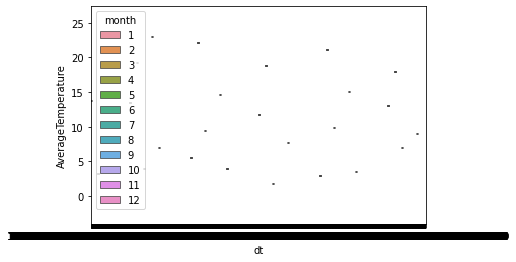

In [15]:
sns.boxplot(x="dt", y="AverageTemperature",data=df_rome, hue="month")

In [16]:
mar_df = df_rome[df_rome.month == 3] 
jan_df = df_rome[df_rome.month == 1] 
jul_df = df_rome[df_rome.month == 7]
nov_df = df_rome[df_rome.month == 11]

In [18]:
mar_df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,month
6399610,1744-03-01,NaN,NaN,Rome,Italy,42.59N,13.09E,3
6399622,1745-03-01,5.606,1.7,Rome,Italy,42.59N,13.09E,3
6399634,1746-03-01,NaN,NaN,Rome,Italy,42.59N,13.09E,3
6399646,1747-03-01,NaN,NaN,Rome,Italy,42.59N,13.09E,3
6399658,1748-03-01,NaN,NaN,Rome,Italy,42.59N,13.09E,3
